# DATA PREPROCESSING (TIỀN XỬ LÝ DỮ LIỆU)
Mục đích: Làm sạch và chuẩn bị dữ liệu cho mô hình
- 1. Load dữ liệu 
- 2. Xử lý Outliers
- 3. Chuẩn hóa biến mục tiêu
- 4. Xử lý dữ liệu thiếu 
- 5. Feature Engineering 
- 6. Xử lý Skewed Features
- 7. Mã hóa dữ liệu (Encoding)
- 8. Lưu dữ liệu sạch



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p


## 1. LOAD DỮ LIỆU 

In [4]:
train_df = pd.read_csv("../data/raw/train.csv")
test_df = pd.read_csv("../data/raw/test.csv")

# Lưu lại ID để dùng cho file submission
train_ID = train_df['Id']
test_ID = test_df['Id']

# Drop cột Id vì không dùng để train
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

print("-" * 66)
print("\t\tDữ liệu đã được tải thành công")
print("-" * 66)

print("Kích thước của tập dữ liệu:")
print(f"- Train shape: {train_df.shape}")
print(f"- Test shape: {test_df.shape}")

------------------------------------------------------------------
		Dữ liệu đã được tải thành công
------------------------------------------------------------------
Kích thước của tập dữ liệu:
- Train shape: (1460, 80)
- Test shape: (1459, 79)


# 2. XỬ LÝ OUTLIERS 

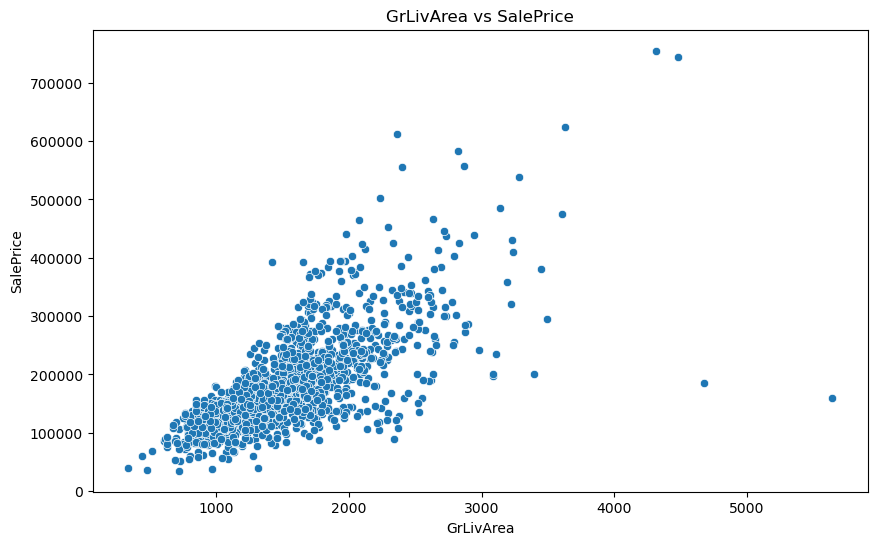

In [5]:
# Trực quan hoá trước khi loại bỏ outliers
def plot_feature_vs_target(data, feature, target):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[feature], y=data[target])
    plt.title(f'{feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()
plot_feature_vs_target(train_df, 'GrLivArea', 'SalePrice')

In [6]:
# Loại bỏ Outliers (Dựa trên EDA: GrLivArea > 4000 và SalePrice < 300000)
outliers = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index
train_df = train_df.drop(outliers)
print(f"Đã loại bỏ {len(outliers)} outliers.")

Đã loại bỏ 2 outliers.


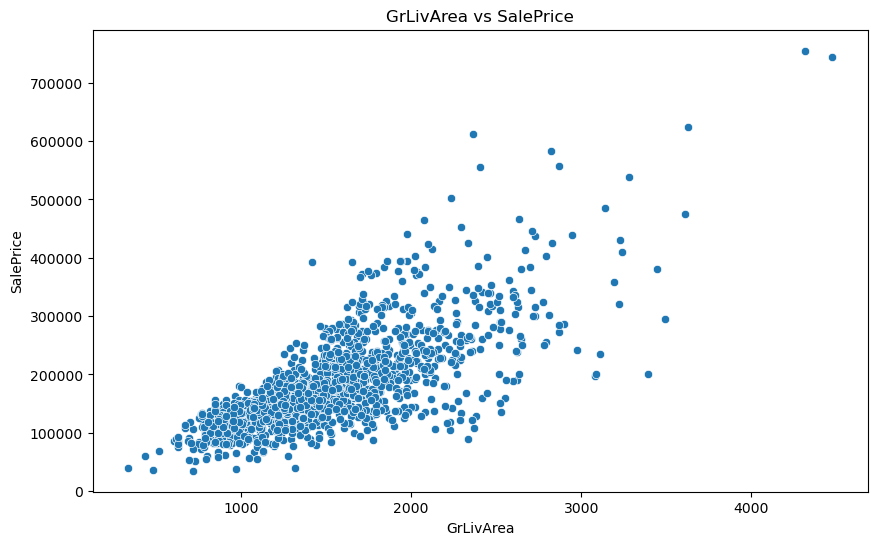

In [7]:
# Trực quan hoá sau khi loại bỏ outliers
plot_feature_vs_target(train_df, 'GrLivArea', 'SalePrice')


# 3. Log Transform SalePrice

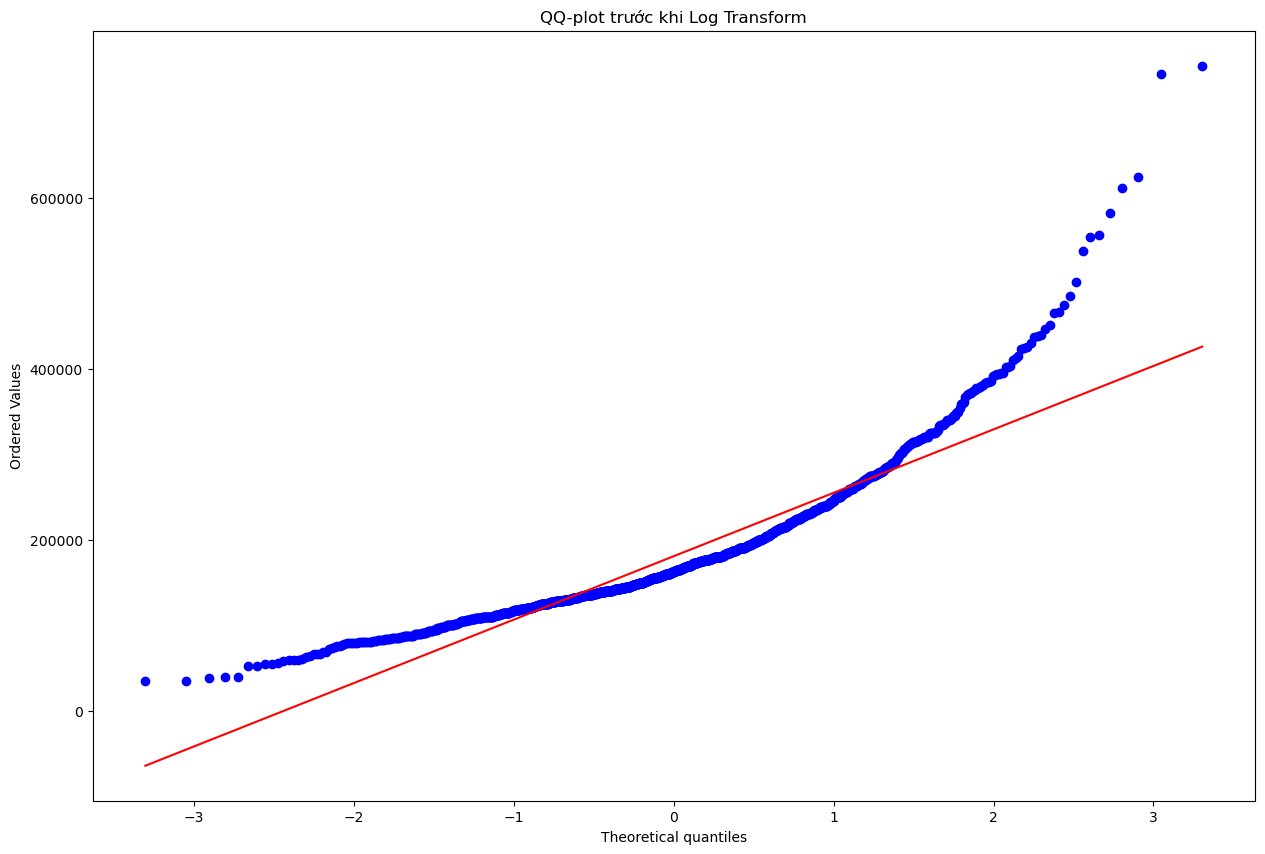

In [8]:
# QQ-plot cho SalePrice
plt.figure(figsize=(15, 10))
stats.probplot(train_df['SalePrice'], plot=plt)
plt.title('QQ-plot trước khi Log Transform')
plt.show()

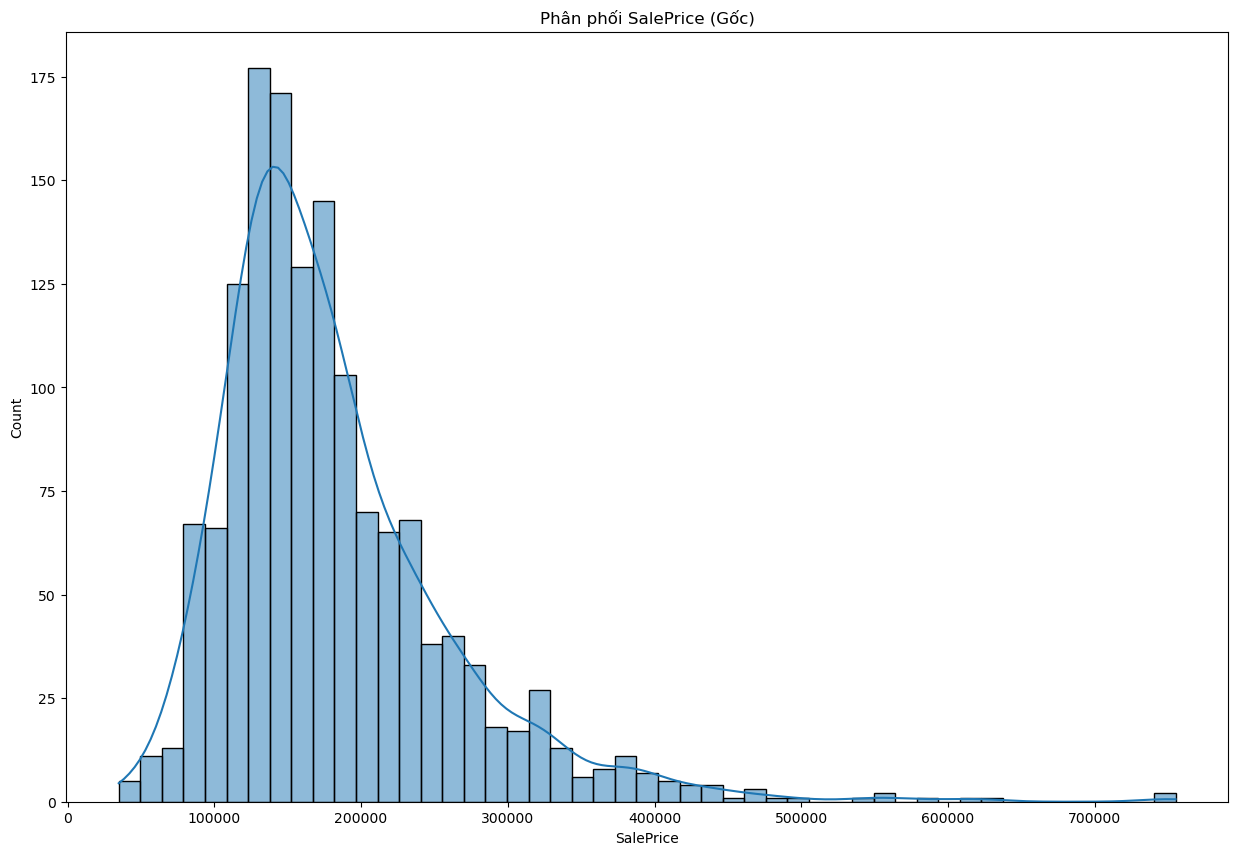

Độ lệch : 1.8828757597682129
Độ nhọn : 6.536281860064529


In [9]:
data_path = '../data/raw/train.csv'
df = pd.read_csv(data_path)
plt.figure(figsize=(15, 10))

# Biểu đồ phân phối gốc
sns.histplot(df['SalePrice'], kde=True)
plt.title('Phân phối SalePrice (Gốc)')
plt.xlabel('SalePrice')
plt.show()

# Kiểm tra độ lệch (Skewness)
print(f"Độ lệch : {df['SalePrice'].skew()}")
print(f"Độ nhọn : {df['SalePrice'].kurt()}")



In [10]:
# Log Transform biến mục tiêu (SalePrice)
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

# Tách biến mục tiêu ra riêng
y_train = train_df.SalePrice.values

# Gộp data để xử lý
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
all_data = pd.concat((train_df.drop(['SalePrice'], axis=1), test_df)).reset_index(drop=True)

print(f"Tổng dữ liệu sau khi gộp: {all_data.shape}")

Tổng dữ liệu sau khi gộp: (2917, 79)


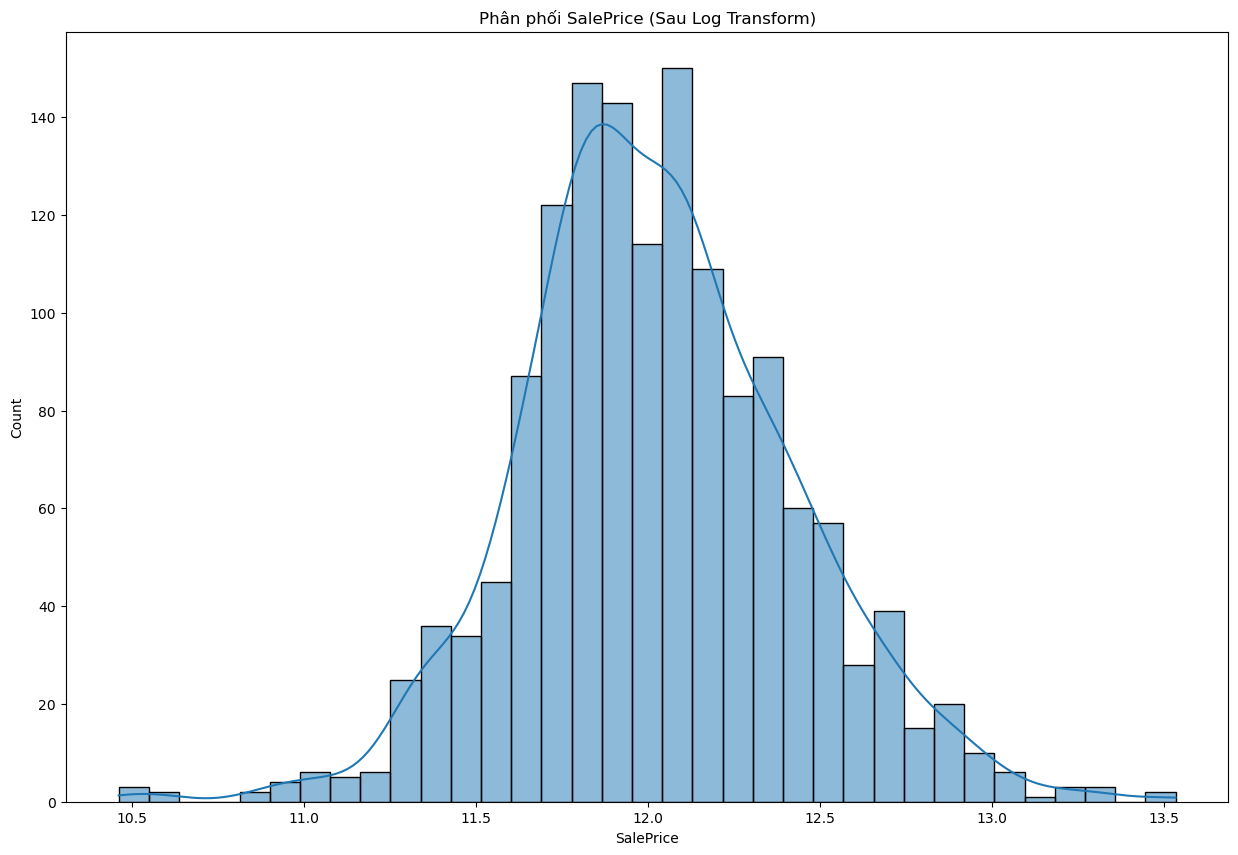

In [11]:
plt.figure(figsize=(15, 10))
# Biểu đồ phân phối sau khi log transform
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Phân phối SalePrice (Sau Log Transform)')
plt.xlabel('SalePrice')
plt.show()

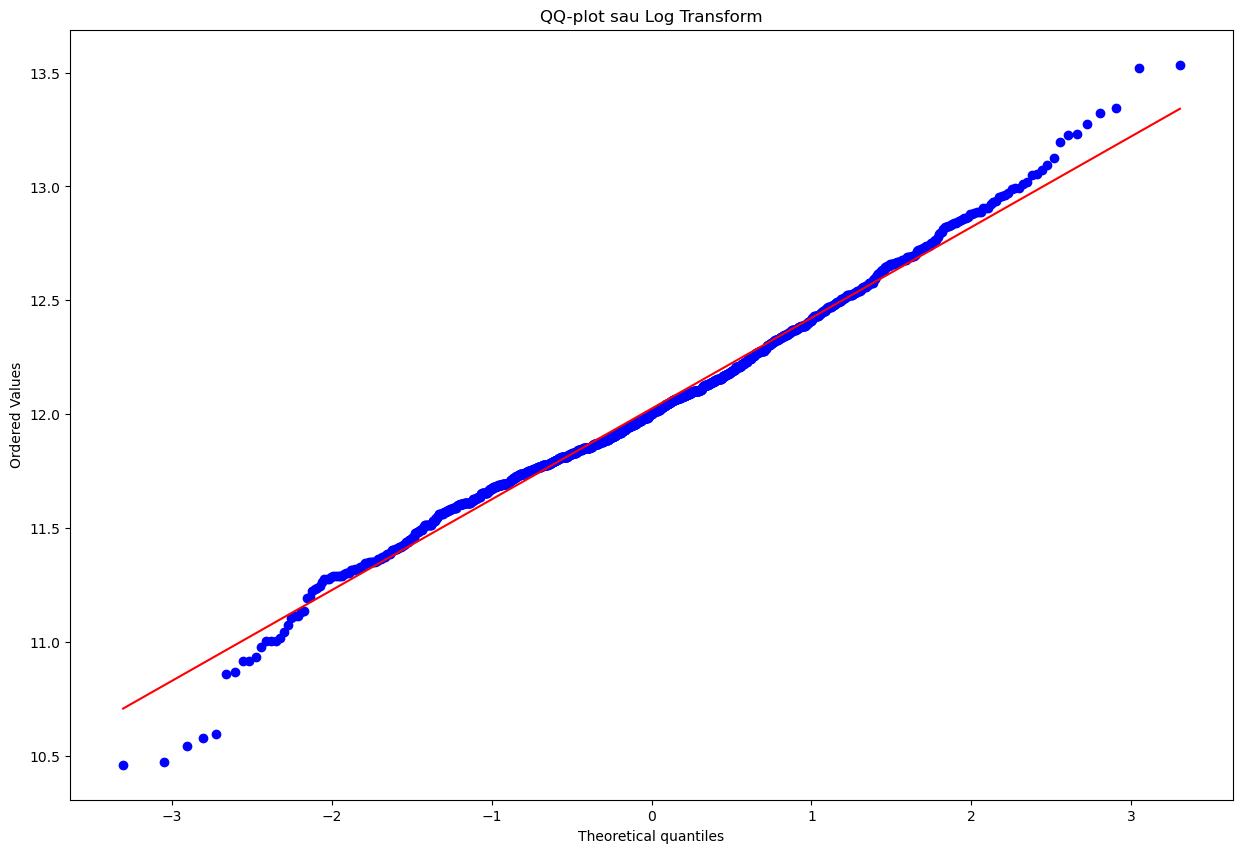

In [10]:
# QQ-plot sau khi log transform
plt.figure(figsize=(15, 10))
stats.probplot(train_df['SalePrice'], plot=plt)
plt.title('QQ-plot sau Log Transform')
plt.show()

# 4. XỬ LÝ MISSING VALUES


In [15]:
missing_count = df.isnull().sum().sort_values(ascending=False)
missing_count = missing_count[missing_count > 0]

print("-" * 66)
print("\t     Kiểm tra giá trị thiếu trong bộ dữ liệu")
print("-" * 66)

if not missing_count.empty:
    display(missing_count.to_frame("Số lượng thiếu").style.background_gradient(cmap='Reds'))
else:
    print("\n * KHÔNG CÓ GIÁ TRỊ NÀO BỊ THIẾU!")

------------------------------------------------------------------
	     Kiểm tra giá trị thiếu trong bộ dữ liệu
------------------------------------------------------------------


,Số lượng thiếu
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


In [18]:
# Nhóm 1: NA nghĩa là "Không có" (None) - Biến phân loại
cols_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']

for col in cols_none:
    all_data[col] = all_data[col].fillna('None')

# Nhóm 2: NA nghĩa là 0 - Biến định lượng
cols_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars',
             'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
             'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

for col in cols_zero:
    all_data[col] = all_data[col].fillna(0)

# Nhóm 3: LotFrontage (Mặt tiền) - Điền bằng median của khu vực lân cận
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Nhóm 4: Các cột còn lại
cols_mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in cols_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Cột Utilities: Loại bỏ vì hầu hết các giá trị đều giống nhau
if 'Utilities' in all_data.columns:
    all_data = all_data.drop(['Utilities'], axis=1)

# Cột Functional: Mặc định là 'Typ' (Typical)
all_data["Functional"] = all_data["Functional"].fillna("Typ")

print("Số lượng missing values còn lại:", all_data.isnull().sum().max())
print("-" * 66)
print("\t\t    Hoàn tất xử lý giá trị thiếu")
print("-" * 66)

all_data.head()

Số lượng missing values còn lại: 0
------------------------------------------------------------------
		    Hoàn tất xử lý giá trị thiếu
------------------------------------------------------------------


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,2566.0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,2524.0
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,2706.0
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,2473.0
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,3343.0


# 5. FEATURE ENGINEERING 

In [14]:
# Chuyển số thành category
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Tạo biến tổng diện tích 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 6. XỬ LÝ SKEWED FEATURES 

In [20]:
# 1. Lọc ra các cột dữ liệu số trong all_data
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 2. Tính độ lệch (Skewness) cho từng cột
# dropna() để tránh lỗi khi tính toán, dù trước đó đã fillna nhưng cẩn thận vẫn hơn
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna().astype(float))).sort_values(ascending=False)
print("-" * 66)
print("\t\tKiểm tra độ lệch của các tính năng số")
print("-" * 66)

# 3. Lọc ra các tính năng có độ lệch cao (thường ngưỡng là > 0.75 hoặc > 0.5)
skewness = skewed_feats[abs(skewed_feats) > 0.75]
print(f"Có {len(skewness)} tính năng số bị lệch cần xử lý:")
print(skewness.head(10)) # In ra 10 tính năng lệch nhất

# 4. Áp dụng biến đổi Box-Cox
# Chúng ta dùng boxcox1p (Box-Cox với 1+x) để xử lý cả số 0
# Lambda = 0 tương đương với log(1+x). 
# Lambda = 0.15 là giá trị thực nghiệm thường cho kết quả tốt trong bài toán này.
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print("-" * 30)
print("Đã hoàn tất biến đổi Box-Cox cho các skewed features.")

------------------------------------------------------------------
		Kiểm tra độ lệch của các tính năng số
------------------------------------------------------------------
Có 12 tính năng số bị lệch cần xử lý:
PoolArea         15.759529
3SsnPorch         8.921650
LowQualFinSF      8.741030
MiscVal           5.594963
BsmtHalfBath      3.786685
KitchenAbvGr      3.697303
ScreenPorch       2.977052
BsmtFinSF2        2.563235
EnclosedPorch     2.024321
LotFrontage      -0.798905
dtype: float64
------------------------------
Đã hoàn tất biến đổi Box-Cox cho các skewed features.


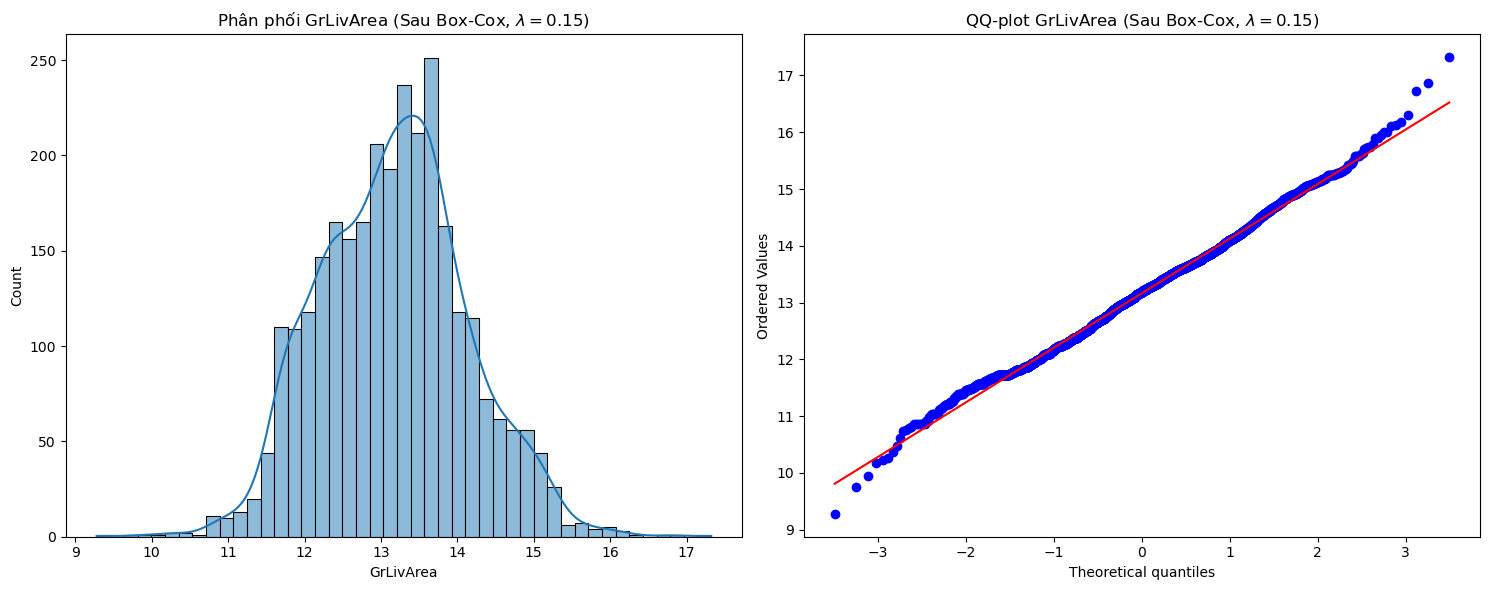

In [21]:
# Trực quan hóa phân phối và QQ-plot của feature sau khi biến đổi.
def plot_skew_correction(data, feature, lam):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Phân phối {feature} (Sau Box-Cox, $\lambda={lam}$)')
    plt.xlabel(feature)

    plt.subplot(1, 2, 2)
    stats.probplot(data[feature], plot=plt)
    plt.title(f'QQ-plot {feature} (Sau Box-Cox, $\lambda={lam}$)')

    plt.tight_layout()
    plt.show()

plot_skew_correction(all_data, 'GrLivArea', 0.15)

# 7. ONE-HOT ENCODING 

In [22]:
all_data = pd.get_dummies(all_data)
print(f"Shape sau encoding: {all_data.shape}")

Shape sau encoding: (2917, 338)


# 8. TÁCH VÀ LƯU DATA 

In [23]:
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

In [24]:
# Tạo thư mục processed nếu chưa có
import os
os.makedirs('../data/processed', exist_ok=True)

X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
pd.DataFrame(y_train, columns=['SalePrice']).to_csv('../data/processed/y_train.csv', index=False)
test_ID.to_csv('../data/processed/test_ID.csv', index=False, header=['Id'])

print(" Đã xử lý và lưu dữ liệu thành công!")

 Đã xử lý và lưu dữ liệu thành công!
